<center><h1> Focal Loss </h1>
John Ignacio R.M. 17 JUN 2020</center>

In [2]:
import numpy as np
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada2.model import BinaryClassifier, Sequential, Dense, Dropout, adagrad
from ada2.data import read_dataset, split_dataset
import pandas as pd
from functools import partial

In [3]:
source_path = "../processed_data/xtohh"
signal = "Xtohh2000"
bg = "Xtohh_background"
seed = 420

In [5]:
#read xtohh dataset
df = read_dataset(source_path, signal, bg, "SR", 2)
sets = split_dataset(df, 0.6, 0.2, 0.2, seed)

FileNotFoundError: [Errno 2] File b'../processed_data/xtohh/Xtohh_background.csv' does not exist: b'../processed_data/xtohh/Xtohh_background.csv'

In [ ]:
from tensorflow import convert_to_tensor, constant, clip_by_value, math
from tensorflow.keras.backend import mean, epsilon
from tensorflow import nn

def get_binary_crossentropy(target, output):
    epsilon_ = constant(epsilon(), output.dtype.base_dtype)
    output = clip_by_value(output, epsilon_, 1. - epsilon_)

    bce = target * math.log(output + epsilon())
    bce += (1 - target) * math.log(1 - output + epsilon())
    return -bce

def keras_binary_crossentropy(y_true, y_pred):
    return mean(get_binary_crossentropy(y_true, y_pred), axis=-1)

def get_focal_loss(target, output, alpha, gamma):
    epsilon_ = constant(epsilon(), output.dtype.base_dtype)
    output = clip_by_value(output, epsilon_, 1. - epsilon_)

    bce = target * math.log(output + epsilon()) * (1 - output)**gamma
    bce += (1 - target) * math.log(1 - output + epsilon()) * (output)**gamma
    return -alpha * bce

def focal_loss(alpha, gamma):

    def focal_loss_aux(y_true, y_pred):
        return mean(get_focal_loss(y_true, y_pred, alpha, gamma), axis=-1)
        
    return focal_loss_aux

def sof_binary_crossentropy(target, output, from_logits=False):
    """Binary crossentropy between an output tensor and a target tensor.

    # Arguments
        target: A tensor with the same shape as `output`.
        output: A tensor.
        from_logits: Whether `output` is expected to be a logits tensor.
            By default, we consider that `output`
            encodes a probability distribution.

    # Returns
        A tensor.
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    if not from_logits:
        # transform back to logits
        _epsilon = convert_to_tensor(epsilon(), dtype = output.dtype.base_dtype)
        output = clip_by_value(output, _epsilon, 1 - _epsilon)
        output = math.log(output / (1 - output))

    bce = nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    return mean(bce, axis = -1)

In [6]:
class BinClassifModel4(BinaryClassifier):

    def __init__(self, n_input, loss):
        #model
        self.model = Sequential()
        #input
        self.model.add(Dense(32, input_dim = n_input, kernel_initializer='uniform',activation='softplus'))
        #hidden layers
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(64, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(256, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(64, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(32, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid'))
        #compile
        self.model.compile(optimizer=adagrad(lr=0.05), loss=loss)

        #training
        self.history = None

        #name
        self.model_name = "BCM4"

In [7]:
from keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()

In [8]:
model = BinClassifModel4(sets["x"]["train"].shape[1], focal_loss(1, 4))
model.fit(
    sets["x"]["train"], sets["y"]["train"], sets["w"]["train"],
    sets["x"]["val"], sets["y"]["val"], sets["w"]["val"],
    50
)

NameError: name 'sets' is not defined

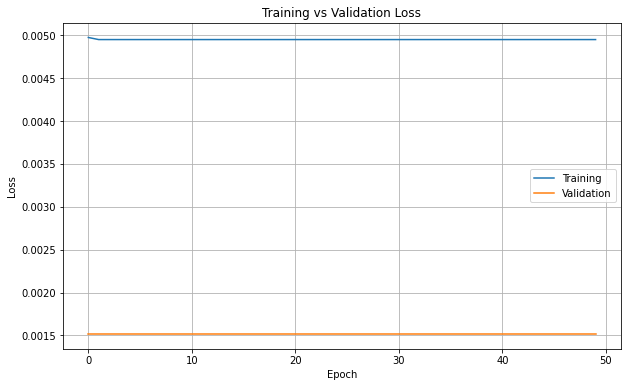

In [8]:
model.plot_loss()